In [1]:
from abc import ABC
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant, safe_logodds, sigmoid
from uncertainty_testbed.uncertainty_models.hla_dropout import HLADropout, HLALinear
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer

from keras import layers
from typing import List, Tuple, Optional, Union
from uncertainty_testbed.uncertainty_models.uncertainty_base import ClassifierPosteriorBase

2022-06-21 16:35:55.505945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 16:35:55.505973: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.01
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [3]:
class Linear(keras.layers.Layer):
    """linear layer performing y = w.x + b without activation"""
    def __init__(self, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros"):
        super(Linear, self).__init__()
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=self.kernel_initializer,
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer=self.bias_initializer, trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


class HLALinear(keras.layers.Layer):
    """Linear classification layer with additive heteroscedastic noise."""
    def __init__(self, samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
                 activation=tf.keras.activations.sigmoid, sigma_scaling=0.1):
        super(HLALinear, self).__init__()
        self.samples = samples
        self.units = units
        self.linear = Linear(units=2*units, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.activation = activation
        self.sigma_scaling = sigma_scaling

    def call(self, inputs: Union[tf.Tensor, np.ndarray], training: Union[None, bool]=None):
        shape = inputs.shape.as_list()[:0] + [self.units, self.samples]  # [batch_size, units, samples]
        eps = tf.random.normal(shape=shape)
        x = self.linear(inputs)
        mu = x[..., :self.units]  # first half of linear is mus
        sigma = 1e-3 + tf.math.softplus(self.sigma_scaling * x[..., self.units:])  # second half with softplus is sigmas
        
        if training:
            logodds = tf.expand_dims(mu, 2) + tf.expand_dims(sigma, 2) * eps
            p = tf.reduce_mean(self.activation(logodds), axis=2)  
            return p, sigma  # note that we return class probability for mu, logit for sigma
        return self.activation(mu), sigma  # note that we return class probability for mu, logit for sigma


class HLAModel(keras.Model):
    """Custom Model class overriding the train step. Here we want to use the model.losses added by the HLALinear layer
    and combine it with the labels using the loss defined during compile (binary or categorical cross entropy).
    """
    def train_step(self, data):
        """"""
        #print()
        #print("----")
        
        x, y = data  # unpack the data

        with tf.GradientTape() as tape:
            y_pred, sigma = self(x, training=True)  # do the forward pass -- we will ignore y_pred in the loss
            loss = self.compiled_loss(y, y_pred)#self.losses[0])  # use self.losses from HLALinear layer instead of predictions
            #print("y shape: %s" % str(y.shape))
            ##print("losses shape: %s" % str(self.losses[0].shape))
        #print("y_pred shape: %s" % str(y_pred.shape))
        #print("sigma shape: %s" % str(sigma.shape))
        #print("loss shape: %s" % str(loss.shape))
        
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics -- here we will use y_pred # TODO this might break - we are not using the actual HLA loss
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metrics to their values
        
        #for m in self.metrics:
        #    print("name/result shape: %s / %s" % (m.name, str(m.result().shape)))
        
        return {m.name: m.result() for m in self.metrics if m.name != "loss"}

In [10]:
class HLADropout(ClassifierPosteriorBase, ABC):
    """Keras classification model with MC Dropout sampling capability."""
    def __init__(self,
                 layer_tuple: Tuple[keras.layers.Layer, ...],
                 optimizer: keras.optimizers.Optimizer,
                 loss: str,
                 metrics: Tuple[str, ...],
                 name: str = "HLADropout"):
        """
                Initialize.
                :param layer_tuple (Tuple[keras.Layer, ...]): Tuple of Keras layers used to construct the model.
                :param optimizer (keras.optimizers.Optimizer):
                :param loss (str):
                :param metrics (Tuple[str, ...]):
                :param name (str):
                """
        # TODO: Add check that the layer tuple contains MC Dropout layers whenever having Dropout.
        ### TODO 4 assert isinstance(layer_tuple[-1], HLALinear)
        super().__init__()
        self.name = name
        self.layer_tuple = layer_tuple
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = [m for m in metrics]
        self.build_model()

    def build_model(self):
        inputs = self.layer_tuple[0]
        for ix, lar in enumerate(self.layer_tuple[1:-1]):
            if ix == 0: x = lar(inputs)
            else: x = lar(x)   
        outputs = self.layer_tuple[-1](x)
        self.model = HLAModel(inputs=inputs, outputs=outputs, name=self.name)### TODO 2 HLAModel(inputs=inputs, outputs=outputs, name=self.name)
        self.model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics,
            run_eagerly=False
        )

    def fit(self, x: Union[np.ndarray, tf.Tensor], y: Union[np.ndarray, tf.Tensor], **kwargs):
        self.model.fit(x, y, **kwargs)


In [11]:
layers = (
    keras.Input(shape=(eg.num_inputs,), name="input"),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    #keras.layers.Dense(1, activation="sigmoid")
    HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
              activation=tf.keras.activations.sigmoid, sigma_scaling=0.1)
)
mcd_classifier = HLADropout(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0084),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="HLADropout"
)

mcd_classifier.model.summary()
mcd_classifier.fit(
    x_train[:24,:],
    y_train[:24],
    epochs=2,
    batch_size=8,
    validation_data=(x_val, y_val)
)

adding first dense layer
Model: "HLADropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 dense_9 (Dense)             (None, 60)                660       
                                                                 
 mc_dropout_layer_9 (MCDropo  (None, 60)               0         
 utLayer)                                                        
                                                                 
 dense_10 (Dense)            (None, 60)                3660      
                                                                 
 mc_dropout_layer_10 (MCDrop  (None, 60)               0         
 outLayer)                                                       
                                                                 
 dense_11 (Dense)            (N

In [4]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

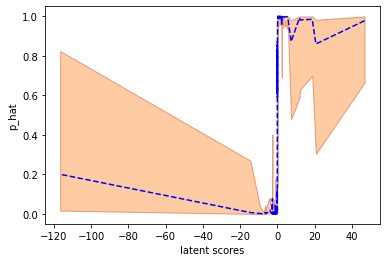

In [5]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

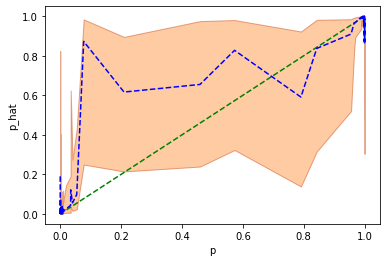

In [6]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [7]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-05-10 14:54:17.189202: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-05-10 14:54:17.273075: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-05-10 14:54:17.282335: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-05-10 14:54:17.347965: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-05-10 14:55:26.044641: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.01: 76.21% within 90% CI


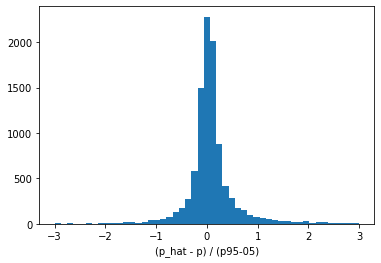

In [8]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.01: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

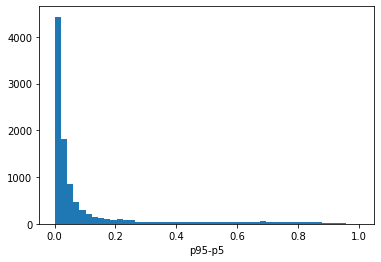

In [9]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [10]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.1
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [11]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=6,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 7s 2ms/step - loss: 0.4025 - accuracy: 0.8235 - auc: 0.9043 - val_loss: 0.3199 - val_accuracy: 0.8832 - val_auc: 0.9388
Epoch 2/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2868 - accuracy: 0.8956 - auc: 0.9488 - val_loss: 0.2756 - val_accuracy: 0.8982 - val_auc: 0.9521
Epoch 3/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2629 - accuracy: 0.9052 - auc: 0.9555 - val_loss: 0.2601 - val_accuracy: 0.9054 - val_auc: 0.9565
Epoch 4/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2509 - accuracy: 0.9112 - auc: 0.9585 - val_loss: 0.2514 - val_accuracy: 0.9100 - val_auc: 0.9587
Epoch 5/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2468 - accuracy: 0.9135 - auc: 0.9595 - val_loss: 0.2519 - val_accuracy: 0.9115 - val_auc: 0.9591
Epoch 6/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2422 - accuracy: 0.9157 - auc: 0.9610 - val_loss

In [12]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

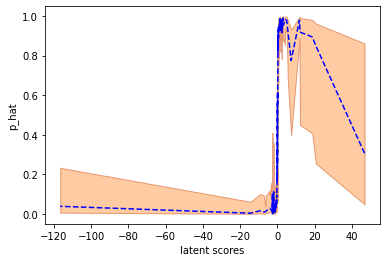

In [13]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

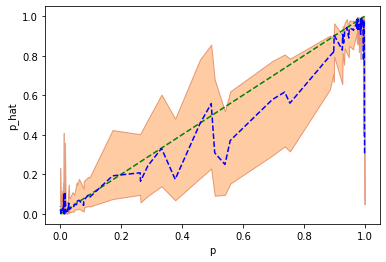

In [14]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [15]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

For noise level: 0.1: 83.2% within 90% CI


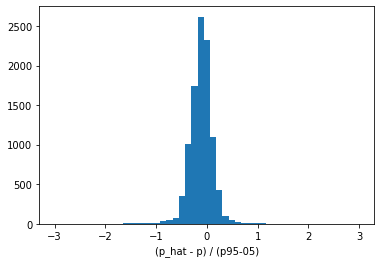

In [16]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.1: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

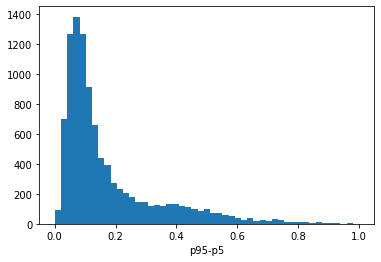

In [17]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [18]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.3
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [19]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=6,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 7s 2ms/step - loss: 0.5118 - accuracy: 0.7591 - auc: 0.8356 - val_loss: 0.4423 - val_accuracy: 0.8130 - val_auc: 0.8823
Epoch 2/6
4160/4160 [==============================] - 7s 2ms/step - loss: 0.4185 - accuracy: 0.8256 - auc: 0.8916 - val_loss: 0.4063 - val_accuracy: 0.8310 - val_auc: 0.8972
Epoch 3/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.3962 - accuracy: 0.8382 - auc: 0.9023 - val_loss: 0.3981 - val_accuracy: 0.8361 - val_auc: 0.9027
Epoch 4/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.3875 - accuracy: 0.8409 - auc: 0.9068 - val_loss: 0.3851 - val_accuracy: 0.8424 - val_auc: 0.9074
Epoch 5/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.3826 - accuracy: 0.8436 - auc: 0.9088 - val_loss: 0.3936 - val_accuracy: 0.8383 - val_auc: 0.9039
Epoch 6/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.3799 - accuracy: 0.8463 - auc: 0.9100 - val_loss

In [20]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

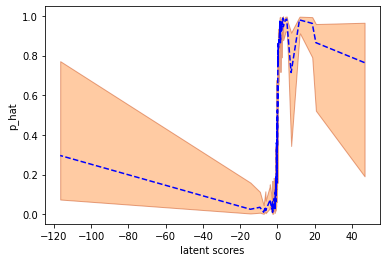

In [21]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

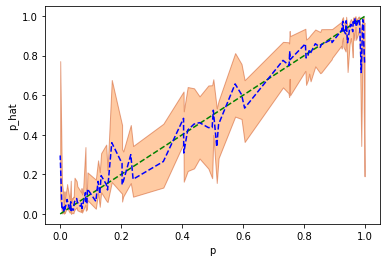

In [22]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [23]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

For noise level: 0.3: 90.86999999999999% within 90% CI


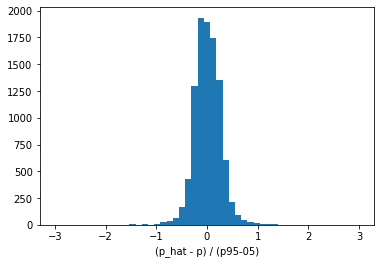

In [24]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.3: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

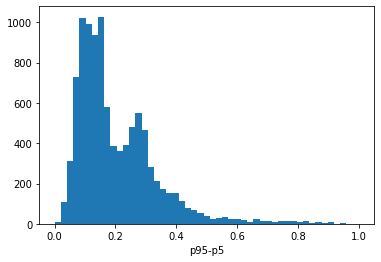

In [25]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()